In [1]:
import time
from IPython.display import display

notebook_start_time = time.perf_counter()
display("Notebook runtime: 0.00s", display_id="notebook_runtime")

'Notebook runtime: 16.38s'

<DisplayHandle display_id=notebook_runtime>

In [2]:
# Parameters
S0 = 100.0
r = 0.02
T = 1.0
K_atm = S0
sigma_true = 0.20
sigma_model_base = 0.18

n_steps = 252
n_paths_list = [5_000, 10_000, 20_000, 40_000]
seed_list = list(range(25))

bump_delta_rel = 1e-4
bump_vega_rel = 1e-4
bump_gamma_rel = 1e-2

variance_reduction_list = ["none", "antithetic", "control_variate"]

# Additional validation figure controls (Notebook 10)
# (Kept separate to avoid changing earlier results.)

# (1) Greeks vs moneyness
moneyness_grid = [0.7, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2, 1.3]
n_paths_moneyness = 80_000
seed_list_moneyness = seed_list[:20]

# (2) FD bump tradeoff (Delta FD)
bump_tradeoff_min = 1e-5
bump_tradeoff_max = 1e-1
bump_tradeoff_n = 17
n_paths_bump_tradeoff = 80_000
seed_list_bump_tradeoff = seed_list[:25]

# (3) Pathwise vs FD Delta comparison
n_paths_compare_list = [2_000, 5_000, 10_000, 20_000, 40_000, 80_000]
seed_list_compare = seed_list[:25]

# (4) CI coverage diagnostic (Delta FD)
n_paths_coverage_list = [2_000, 5_000, 10_000, 20_000, 40_000]
seed_list_coverage = list(range(120))

In [3]:
import os
import sys

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from src.gbm import simulate_gbm_paths
from src.pricing import black_scholes_call
from src.greeks import (
    bs_delta_call,
    bs_gamma,
    bs_vega,
    delta_fd_call,
    delta_pathwise_call,
    gamma_fd_call,
    vega_fd_call,
)

In [5]:
figures_dir = os.path.join(parent_dir, "figures", "notebooks", "10_volatility_and_greeks")
os.makedirs(figures_dir, exist_ok=True)

sns.set_theme(style="whitegrid")
np.set_printoptions(precision=6, suppress=True)

# 10 Volatility and Greeks

This notebook studies **estimation quality and robustness** for option Greeks under the Black–Scholes / GBM model.

**What this is**
- A diagnostics notebook: estimator noise, variance reduction, bump-size sensitivity, and volatility mis-specification.

**What this is not**
- Not a trading strategy or hedging recommendation.

**Assumptions**
- Risk-neutral GBM with constant volatility.
- European call payoff.

**How to run**
- Run top-to-bottom on a clean kernel.
- Figures are saved under `figures/10_volatility_and_greeks/` with deterministic filenames.


## Notebook map

1. **Baseline references**: analytical BS price/Greeks at `sigma_true` and `sigma_model_base`.
2. **Estimator noise vs paths**: how MC error falls with more paths.
3. **Variance reduction**: how antithetic / control variates affect stability.
4. **Model risk**: sensitivity to volatility mis-specification.
5. **Additional validation**: moneyness overlays, bump tradeoff, pathwise vs FD, CI coverage.
6. **Toy hedging** (illustrative): discrete re-hedging error under mis-specified volatility.


## Helpers

**Parameters live in the first cell** so results are reproducible.

Conventions used throughout:
- **Finite differences (FD)** use the implementations in `src/greeks.py`.
- **Common random numbers (CRN)** are achieved by passing a fixed `seed` (internally reusing the same normal draws for the up/down bump).
- **Variance reduction** modes are `"none"`, `"antithetic"`, `"control_variate"` as implemented in the existing APIs.

Bump sizes follow Notebook 00 validation:
- `bump_delta_rel = 1e-4` (absolute bump passed directly to `delta_fd_call`)
- `bump_vega_rel = 1e-4` (absolute bump passed directly to `vega_fd_call`)
- `bump_gamma_rel = 1e-2` (converted to an absolute spot bump `bump_gamma_rel * S0`)


## Glossary (quick)

- **CRN (common random numbers)**: reuse randomness across perturbed simulations to reduce FD noise.
- **FD (finite differences)**: estimate sensitivity via bumped revaluation (central differences here).
- **Pathwise estimator**: differentiate the payoff along simulated paths (valid for Delta of a European call under GBM).
- **CI (confidence interval)**: here, a normal-approximation CI from the sample variance across paths.
- **Variance reduction**: techniques to reduce estimator variance without increasing `n_paths`.


In [6]:
bump_delta = bump_delta_rel
bump_vega = bump_vega_rel
bump_gamma = bump_gamma_rel * S0


def bs_refs(sigma: float) -> dict:
    return {
        "price": black_scholes_call(S0, K_atm, T, r, sigma),
        "delta": bs_delta_call(S0, K_atm, T, r, sigma),
        "gamma": bs_gamma(S0, K_atm, T, r, sigma),
        "vega": bs_vega(S0, K_atm, T, r, sigma),
    }


def safe_rel_error(value: float, ref: float, eps: float = 1e-12) -> float:
    denom = max(abs(ref), eps)
    return (value - ref) / denom


def mc_greeks(
    sigma: float,
    n_paths: int,
    seed: int,
    variance_reduction: str = "none",
) -> dict:
    delta_fd = delta_fd_call(
        S0,
        K_atm,
        T,
        r,
        sigma,
        n_paths,
        seed=seed,
        bump=bump_delta,
        variance_reduction=variance_reduction,
    )
    delta_pw = delta_pathwise_call(
        S0, K_atm, T, r, sigma, n_paths, seed=seed, variance_reduction=variance_reduction
    )
    vega_fd = vega_fd_call(
        S0,
        K_atm,
        T,
        r,
        sigma,
        n_paths,
        seed=seed,
        bump=bump_vega,
        variance_reduction=variance_reduction,
    )
    gamma_fd = gamma_fd_call(
        S0,
        K_atm,
        T,
        r,
        sigma,
        n_paths,
        seed=seed,
        bump=bump_gamma,
        variance_reduction=variance_reduction,
    )
    return {
        "delta_fd": delta_fd,
        "delta_pw": delta_pw,
        "vega_fd": vega_fd,
        "gamma_fd": gamma_fd,
    }


def bs_delta_call_vec(S: np.ndarray, K: float, T: float, r: float, sigma: float) -> np.ndarray:
    S = np.asarray(S, dtype=float)
    if T <= 0:
        return np.where(S > K, 1.0, 0.0)
    if sigma <= 0:
        return np.where(S > K * np.exp(-r * T), 1.0, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

## Baseline Greeks (Black–Scholes reference)

We keep two volatility notions explicit:
- `sigma_true`: the assumed “true” data-generating volatility for simulation thought experiments.
- `sigma_model_base`: the volatility used by the model/desk for pricing/Greeks.

This separation is used later for **model risk framing**: parameter error can dominate Monte Carlo noise.


In [7]:
bs_true = bs_refs(sigma_true)
bs_model = bs_refs(sigma_model_base)

print("True sigma:", sigma_true)
print(bs_true)
print("Model sigma:", sigma_model_base)
print(bs_model)

True sigma: 0.2
{'price': 8.916037278572539, 'delta': 0.579259709439103, 'gamma': 0.019552134698772795, 'vega': 39.104269397545586}
Model sigma: 0.18
{'price': 8.134008370826223, 'delta': 0.5796941529586114, 'gamma': 0.02171975355127819, 'vega': 39.09555639230074}


## Estimator noise vs number of paths

For each `n_paths` and each seed, we compute Greek estimates and then aggregate across seeds.

Metrics:
- **Std across seeds**: run-to-run stability at a fixed path budget.
- **RMSE vs BS**: combined bias + variance relative to analytical BS (at `sigma_model_base`).

Reading tip: with a correct implementation, you typically expect slopes close to `O(1/\sqrt{n_paths})` for noise-driven regimes.


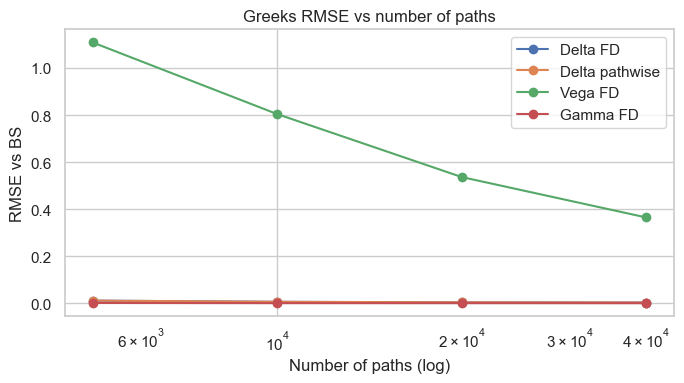

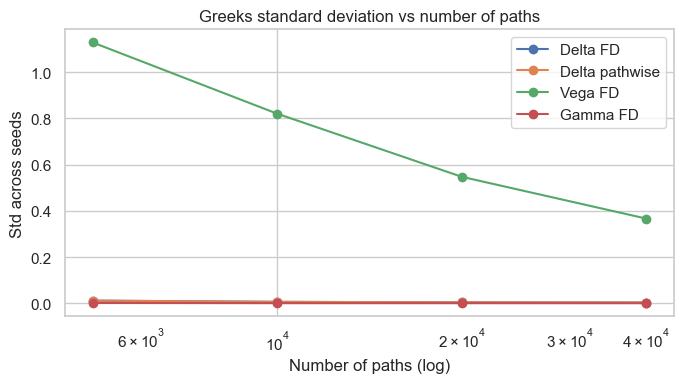

In [8]:
methods = ["delta_fd", "delta_pw", "vega_fd", "gamma_fd"]

estimates = {m: np.zeros((len(n_paths_list), len(seed_list))) for m in methods}

for i, n_paths in enumerate(n_paths_list):
    for j, seed in enumerate(seed_list):
        results = mc_greeks(sigma_model_base, n_paths, seed, variance_reduction="none")
        for m in methods:
            estimates[m][i, j] = results[m].estimate

bs_ref = bs_refs(sigma_model_base)
ref_map = {
    "delta_fd": bs_ref["delta"],
    "delta_pw": bs_ref["delta"],
    "vega_fd": bs_ref["vega"],
    "gamma_fd": bs_ref["gamma"],
}

rmse = {}
std = {}
mean = {}
for m in methods:
    mean[m] = estimates[m].mean(axis=1)
    std[m] = estimates[m].std(axis=1, ddof=1)
    rmse[m] = np.sqrt(((estimates[m] - ref_map[m]) ** 2).mean(axis=1))

plt.figure(figsize=(7, 4))
for m, label in [
    ("delta_fd", "Delta FD"),
    ("delta_pw", "Delta pathwise"),
    ("vega_fd", "Vega FD"),
    ("gamma_fd", "Gamma FD"),
]:
    plt.plot(n_paths_list, rmse[m], marker="o", label=label)
plt.xscale("log")
plt.xlabel("Number of paths (log)")
plt.ylabel("RMSE vs BS")
plt.title("Greeks RMSE vs number of paths")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "greeks_rmse_vs_paths.png"), dpi=150)
plt.show()

plt.figure(figsize=(7, 4))
for m, label in [
    ("delta_fd", "Delta FD"),
    ("delta_pw", "Delta pathwise"),
    ("vega_fd", "Vega FD"),
    ("gamma_fd", "Gamma FD"),
]:
    plt.plot(n_paths_list, std[m], marker="o", label=label)
plt.xscale("log")
plt.xlabel("Number of paths (log)")
plt.ylabel("Std across seeds")
plt.title("Greeks standard deviation vs number of paths")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "greeks_std_vs_paths.png"), dpi=150)
plt.show()

## Variance reduction impact on Greek stability

Holding the path budget fixed, we compare how variance reduction schemes change:
- **Std across seeds** (stability), and
- **Mean absolute error vs BS** (accuracy proxy).

This is a practical way to decide whether to spend compute on more paths or better variance reduction.


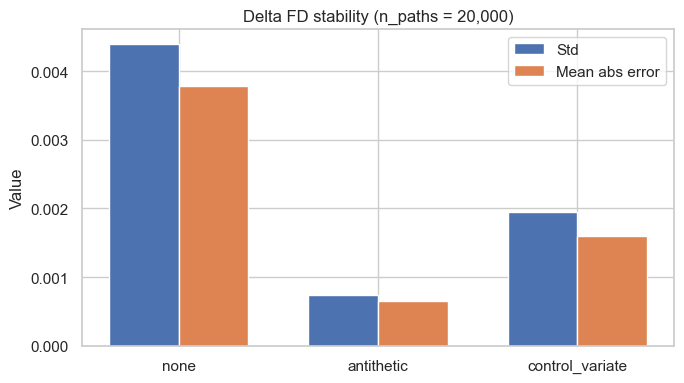

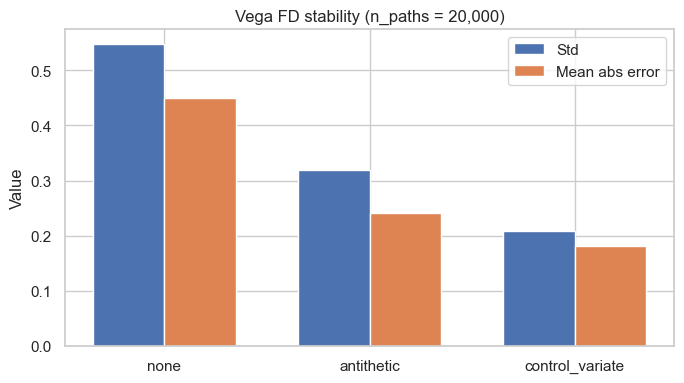

In [9]:
n_paths_mid = n_paths_list[len(n_paths_list) // 2]

vr_delta = {vr: [] for vr in variance_reduction_list}
vr_vega = {vr: [] for vr in variance_reduction_list}

for vr in variance_reduction_list:
    for seed in seed_list:
        results = mc_greeks(sigma_model_base, n_paths_mid, seed, variance_reduction=vr)
        vr_delta[vr].append(results["delta_fd"].estimate)
        vr_vega[vr].append(results["vega_fd"].estimate)

vr_stats_delta = {}
vr_stats_vega = {}
for vr in variance_reduction_list:
    delta_vals = np.array(vr_delta[vr])
    vega_vals = np.array(vr_vega[vr])
    vr_stats_delta[vr] = {
        "std": float(delta_vals.std(ddof=1)),
        "mae": float(np.mean(np.abs(delta_vals - bs_ref["delta"]))),
    }
    vr_stats_vega[vr] = {
        "std": float(vega_vals.std(ddof=1)),
        "mae": float(np.mean(np.abs(vega_vals - bs_ref["vega"]))),
    }

x = np.arange(len(variance_reduction_list))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(
    x - width / 2, [vr_stats_delta[vr]["std"] for vr in variance_reduction_list], width, label="Std"
)
plt.bar(
    x + width / 2,
    [vr_stats_delta[vr]["mae"] for vr in variance_reduction_list],
    width,
    label="Mean abs error",
)
plt.xticks(x, variance_reduction_list)
plt.ylabel("Value")
plt.title(f"Delta FD stability (n_paths = {n_paths_mid:,})")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "vr_effect_delta_fd.png"), dpi=150)
plt.show()

plt.figure(figsize=(7, 4))
plt.bar(
    x - width / 2, [vr_stats_vega[vr]["std"] for vr in variance_reduction_list], width, label="Std"
)
plt.bar(
    x + width / 2,
    [vr_stats_vega[vr]["mae"] for vr in variance_reduction_list],
    width,
    label="Mean abs error",
)
plt.xticks(x, variance_reduction_list)
plt.ylabel("Value")
plt.title(f"Vega FD stability (n_paths = {n_paths_mid:,})")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "vr_effect_vega_fd.png"), dpi=150)
plt.show()

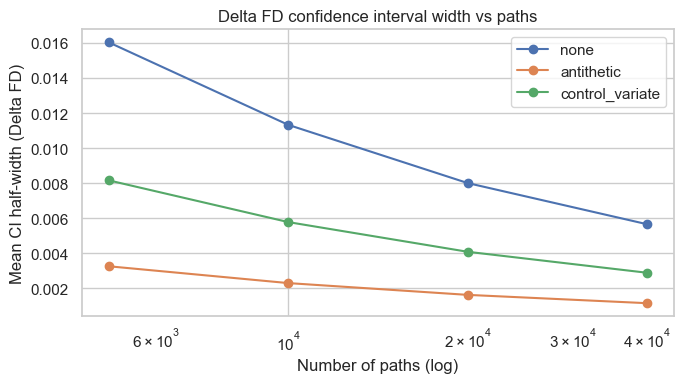

In [10]:
seed_list_ci = seed_list[:10]
ci_halfwidth = {vr: [] for vr in variance_reduction_list}

for vr in variance_reduction_list:
    for n_paths in n_paths_list:
        half_widths = []
        for seed in seed_list_ci:
            res = delta_fd_call(
                S0,
                K_atm,
                T,
                r,
                sigma_model_base,
                n_paths,
                seed=seed,
                bump=bump_delta,
                variance_reduction=vr,
            )
            half_widths.append(0.5 * (res.ci[1] - res.ci[0]))
        ci_halfwidth[vr].append(float(np.mean(half_widths)))

plt.figure(figsize=(7, 4))
for vr in variance_reduction_list:
    plt.plot(n_paths_list, ci_halfwidth[vr], marker="o", label=vr)
plt.xscale("log")
plt.xlabel("Number of paths (log)")
plt.ylabel("Mean CI half-width (Delta FD)")
plt.title("Delta FD confidence interval width vs paths")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "delta_fd_ci_halfwidth_vs_paths.png"), dpi=150)
plt.show()

## Sensitivity to volatility mis-specification (model risk framing)

Here we treat volatility as a **model parameter** rather than a known constant.

We sweep `sigma_model` around `sigma_true` and measure:
- how the **price** and **Greeks** move (level sensitivity), and
- the **relative error vs truth** (using `sigma_true` as the reference).

Takeaway: even if MC noise is small, parameter mis-specification can create materially wrong sensitivities.


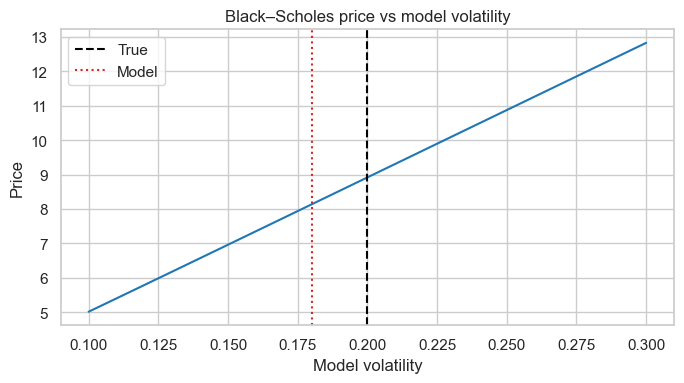

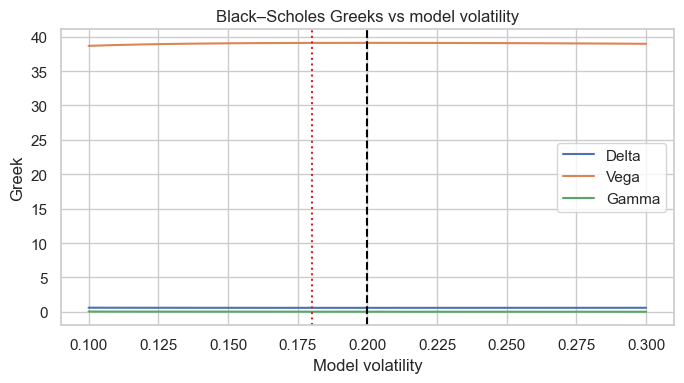

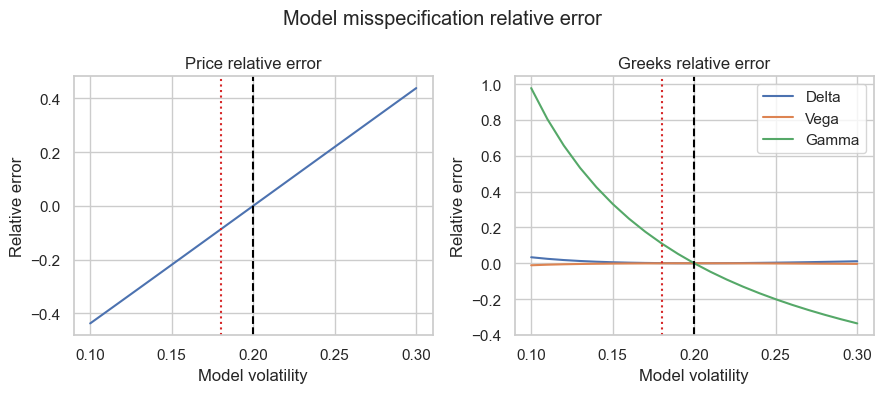

In [11]:
sigma_model_grid = np.linspace(0.5 * sigma_true, 1.5 * sigma_true, 21)

price_curve = [black_scholes_call(S0, K_atm, T, r, s) for s in sigma_model_grid]
delta_curve = [bs_delta_call(S0, K_atm, T, r, s) for s in sigma_model_grid]
vega_curve = [bs_vega(S0, K_atm, T, r, s) for s in sigma_model_grid]
gamma_curve = [bs_gamma(S0, K_atm, T, r, s) for s in sigma_model_grid]

plt.figure(figsize=(7, 4))
plt.plot(sigma_model_grid, price_curve, color="tab:blue")
plt.axvline(sigma_true, color="black", linestyle="--", label="True")
plt.axvline(sigma_model_base, color="tab:red", linestyle=":", label="Model")
plt.xlabel("Model volatility")
plt.ylabel("Price")
plt.title("Black–Scholes price vs model volatility")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "bs_price_vs_sigma_model.png"), dpi=150)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(sigma_model_grid, delta_curve, label="Delta")
plt.plot(sigma_model_grid, vega_curve, label="Vega")
plt.plot(sigma_model_grid, gamma_curve, label="Gamma")
plt.axvline(sigma_true, color="black", linestyle="--")
plt.axvline(sigma_model_base, color="tab:red", linestyle=":")
plt.xlabel("Model volatility")
plt.ylabel("Greek")
plt.title("Black–Scholes Greeks vs model volatility")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "bs_greeks_vs_sigma_model.png"), dpi=150)
plt.show()

ref_price = black_scholes_call(S0, K_atm, T, r, sigma_true)
ref_delta = bs_delta_call(S0, K_atm, T, r, sigma_true)
ref_vega = bs_vega(S0, K_atm, T, r, sigma_true)
ref_gamma = bs_gamma(S0, K_atm, T, r, sigma_true)

rel_err_price = [safe_rel_error(p, ref_price) for p in price_curve]
rel_err_delta = [safe_rel_error(d, ref_delta) for d in delta_curve]
rel_err_vega = [safe_rel_error(v, ref_vega) for v in vega_curve]
rel_err_gamma = [safe_rel_error(g, ref_gamma) for g in gamma_curve]

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
axes[0].plot(sigma_model_grid, rel_err_price, label="Price")
axes[0].axvline(sigma_true, color="black", linestyle="--")
axes[0].axvline(sigma_model_base, color="tab:red", linestyle=":")
axes[0].set_title("Price relative error")

axes[1].plot(sigma_model_grid, rel_err_delta, label="Delta")
axes[1].plot(sigma_model_grid, rel_err_vega, label="Vega")
axes[1].plot(sigma_model_grid, rel_err_gamma, label="Gamma")
axes[1].axvline(sigma_true, color="black", linestyle="--")
axes[1].axvline(sigma_model_base, color="tab:red", linestyle=":")
axes[1].set_title("Greeks relative error")
axes[1].legend()

for ax in axes:
    ax.set_xlabel("Model volatility")
    ax.set_ylabel("Relative error")

plt.suptitle("Model misspecification relative error")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "model_misspec_rel_error.png"), dpi=150)
plt.show()

**Interpretation**
- Volatility enters the BS surface nonlinearly; “small” sigma errors can create outsized price/Greek errors.
- In many workflows, **calibration/parameter risk** dominates residual MC noise.
- This motivates monitoring both estimator uncertainty (CI / RMSE) and model uncertainty (sigma ranges).


## Additional validation figures

These figures add “sanity checks” that mirror typical desk/quant QA:
- cross-sectional shape vs strike (moneyness),
- FD bump tradeoffs,
- estimator comparisons,
- and CI coverage.

All estimators come from existing functions in `src/greeks.py` and are called from the notebook without introducing new estimator logic.


### (1) Greeks vs moneyness with analytical overlay

We plot Greeks as a function of **moneyness** `K / S0` (x-axis).

- Points/line: MC estimate **averaged across seeds**.
- Shaded band: a **95% CI for the mean across seeds** (to visualize stability).
- Solid line: analytical Black–Scholes Greek.

If you see systematic deviations that do not shrink with more paths, that suggests **bias** (bump choice, discretization assumptions, or implementation issues).


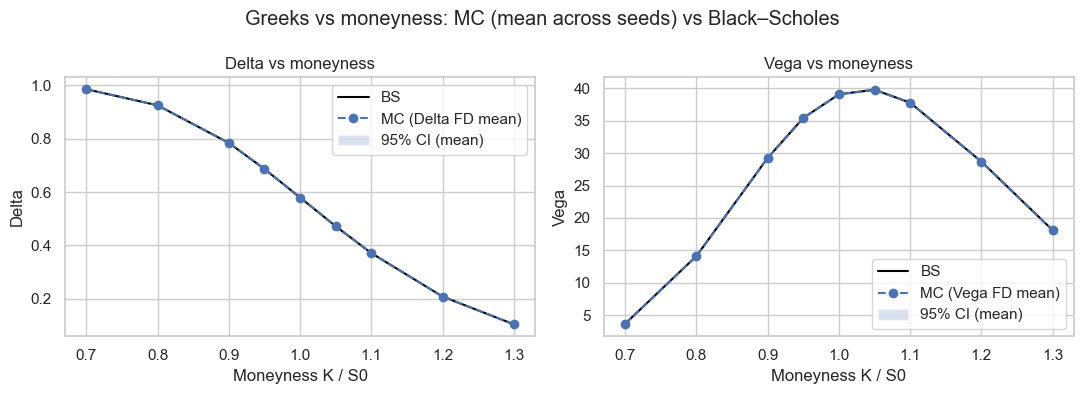

In [12]:
K_list = [float(m * S0) for m in moneyness_grid]
x = np.array([K / S0 for K in K_list], dtype=float)

mc_delta_mean = []
mc_delta_ci_lo = []
mc_delta_ci_hi = []
mc_vega_mean = []
mc_vega_ci_lo = []
mc_vega_ci_hi = []

z = 1.959963984540054

for K in K_list:
    delta_est = []
    vega_est = []

    for seed in seed_list_moneyness:
        d = delta_fd_call(
            S0,
            K,
            T,
            r,
            sigma_model_base,
            n_paths_moneyness,
            seed=seed,
            bump=bump_delta,
            variance_reduction="none",
        ).estimate
        v = vega_fd_call(
            S0,
            K,
            T,
            r,
            sigma_model_base,
            n_paths_moneyness,
            seed=seed,
            bump=bump_vega,
            variance_reduction="none",
        ).estimate
        delta_est.append(d)
        vega_est.append(v)

    delta_est = np.array(delta_est, dtype=float)
    vega_est = np.array(vega_est, dtype=float)

    d_mean = float(delta_est.mean())
    v_mean = float(vega_est.mean())

    d_se = float(delta_est.std(ddof=1) / np.sqrt(delta_est.size))
    v_se = float(vega_est.std(ddof=1) / np.sqrt(vega_est.size))

    mc_delta_mean.append(d_mean)
    mc_delta_ci_lo.append(d_mean - z * d_se)
    mc_delta_ci_hi.append(d_mean + z * d_se)

    mc_vega_mean.append(v_mean)
    mc_vega_ci_lo.append(v_mean - z * v_se)
    mc_vega_ci_hi.append(v_mean + z * v_se)

bs_delta_curve = [bs_delta_call(S0, K, T, r, sigma_model_base) for K in K_list]
bs_vega_curve = [bs_vega(S0, K, T, r, sigma_model_base) for K in K_list]

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True)

axes[0].plot(x, bs_delta_curve, color="black", label="BS")
axes[0].plot(x, mc_delta_mean, marker="o", linestyle="--", label="MC (Delta FD mean)")
axes[0].fill_between(x, mc_delta_ci_lo, mc_delta_ci_hi, alpha=0.2, label="95% CI (mean)")
axes[0].set_xlabel("Moneyness K / S0")
axes[0].set_ylabel("Delta")
axes[0].set_title("Delta vs moneyness")
axes[0].legend(loc="best")

axes[1].plot(x, bs_vega_curve, color="black", label="BS")
axes[1].plot(x, mc_vega_mean, marker="o", linestyle="--", label="MC (Vega FD mean)")
axes[1].fill_between(x, mc_vega_ci_lo, mc_vega_ci_hi, alpha=0.2, label="95% CI (mean)")
axes[1].set_xlabel("Moneyness K / S0")
axes[1].set_ylabel("Vega")
axes[1].set_title("Vega vs moneyness")
axes[1].legend(loc="best")

plt.suptitle("Greeks vs moneyness: MC (mean across seeds) vs Black–Scholes")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "greeks_vs_moneyness_overlay.png"), dpi=150)
plt.show()

### (2) Finite-difference bump-size bias–variance tradeoff (Delta FD)

Central finite differences face a classic tradeoff:
- **Too small bump** → numerical cancellation + amplified Monte Carlo noise.
- **Too large bump** → truncation bias (derivative approximation error).

We sweep the bump on a log grid and measure error vs the analytical BS Delta at a fixed point.
The default bump used elsewhere is shown as a vertical reference line.


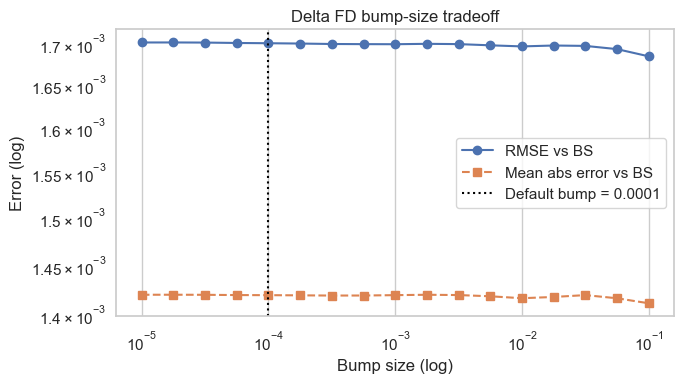

In [13]:
bump_grid = np.logspace(np.log10(bump_tradeoff_min), np.log10(bump_tradeoff_max), bump_tradeoff_n)

bs_delta_ref = bs_delta_call(S0, K_atm, T, r, sigma_model_base)

rmse_by_bump = []
mean_abs_err_by_bump = []

for bump in bump_grid:
    vals = []
    for seed in seed_list_bump_tradeoff:
        vals.append(
            delta_fd_call(
                S0,
                K_atm,
                T,
                r,
                sigma_model_base,
                n_paths_bump_tradeoff,
                seed=seed,
                bump=float(bump),
                variance_reduction="none",
            ).estimate
        )
    vals = np.array(vals, dtype=float)
    rmse_by_bump.append(float(np.sqrt(np.mean((vals - bs_delta_ref) ** 2))))
    mean_abs_err_by_bump.append(float(np.mean(np.abs(vals - bs_delta_ref))))

plt.figure(figsize=(7, 4))
plt.plot(bump_grid, rmse_by_bump, marker="o", label="RMSE vs BS")
plt.plot(bump_grid, mean_abs_err_by_bump, marker="s", linestyle="--", label="Mean abs error vs BS")
plt.axvline(bump_delta, color="black", linestyle=":", label=f"Default bump = {bump_delta:g}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Bump size (log)")
plt.ylabel("Error (log)")
plt.title("Delta FD bump-size tradeoff")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "fd_bump_tradeoff_delta.png"), dpi=150)
plt.show()

### (3) Pathwise vs finite-difference Delta comparison

For a European call under GBM, Delta admits a pathwise estimator.

We compare **RMSE vs number of paths** (log–log) between:
- **Pathwise Delta**, and
- **FD Delta** (central differences with CRN via fixed seeds).

This helps decide which estimator is preferable at a given compute budget.


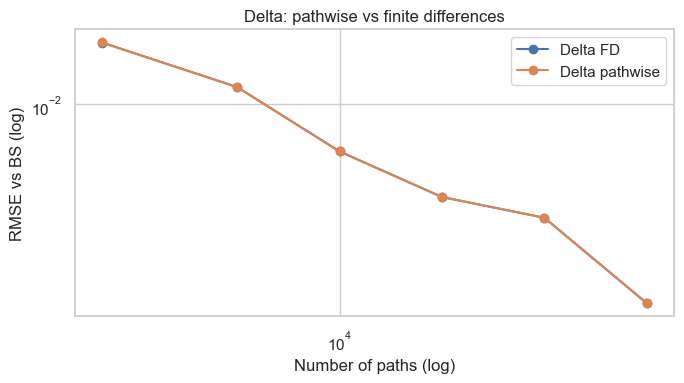

In [14]:
bs_delta_ref = bs_delta_call(S0, K_atm, T, r, sigma_model_base)

rmse_fd = []
rmse_pw = []

for n_paths in n_paths_compare_list:
    fd_vals = []
    pw_vals = []
    for seed in seed_list_compare:
        fd_vals.append(
            delta_fd_call(
                S0,
                K_atm,
                T,
                r,
                sigma_model_base,
                n_paths,
                seed=seed,
                bump=bump_delta,
                variance_reduction="none",
            ).estimate
        )
        pw_vals.append(
            delta_pathwise_call(
                S0,
                K_atm,
                T,
                r,
                sigma_model_base,
                n_paths,
                seed=seed,
                variance_reduction="none",
            ).estimate
        )

    fd_vals = np.array(fd_vals, dtype=float)
    pw_vals = np.array(pw_vals, dtype=float)

    rmse_fd.append(float(np.sqrt(np.mean((fd_vals - bs_delta_ref) ** 2))))
    rmse_pw.append(float(np.sqrt(np.mean((pw_vals - bs_delta_ref) ** 2))))

plt.figure(figsize=(7, 4))
plt.plot(n_paths_compare_list, rmse_fd, marker="o", label="Delta FD")
plt.plot(n_paths_compare_list, rmse_pw, marker="o", label="Delta pathwise")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of paths (log)")
plt.ylabel("RMSE vs BS (log)")
plt.title("Delta: pathwise vs finite differences")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "delta_pathwise_vs_fd.png"), dpi=150)
plt.show()

### (4) Confidence-interval coverage diagnostic (Delta)

A 95% CI should contain the truth about 95% of the time **if**:
- the estimator is unbiased (or bias is negligible), and
- the normal approximation is reasonable.

We estimate coverage empirically by repeating runs across many seeds and checking whether the analytical BS Delta falls inside each estimated 95% CI.


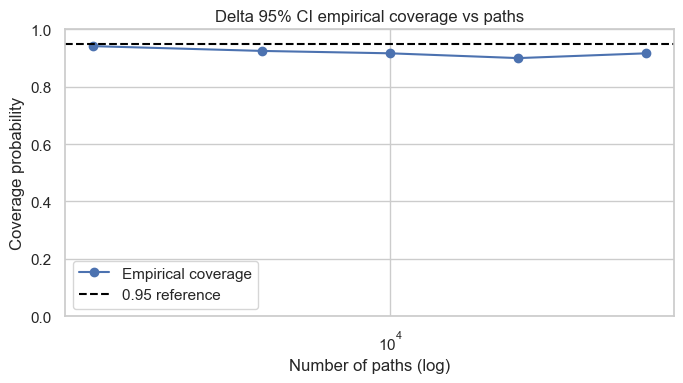

In [15]:
bs_delta_ref = bs_delta_call(S0, K_atm, T, r, sigma_model_base)

coverage = []

for n_paths in n_paths_coverage_list:
    hits = 0
    for seed in seed_list_coverage:
        res = delta_fd_call(
            S0,
            K_atm,
            T,
            r,
            sigma_model_base,
            n_paths,
            seed=seed,
            bump=bump_delta,
            variance_reduction="none",
        )
        if res.ci[0] <= bs_delta_ref <= res.ci[1]:
            hits += 1
    coverage.append(hits / len(seed_list_coverage))

plt.figure(figsize=(7, 4))
plt.plot(n_paths_coverage_list, coverage, marker="o", label="Empirical coverage")
plt.axhline(0.95, color="black", linestyle="--", label="0.95 reference")
plt.xscale("log")
plt.ylim(0.0, 1.0)
plt.xlabel("Number of paths (log)")
plt.ylabel("Coverage probability")
plt.title("Delta 95% CI empirical coverage vs paths")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "delta_ci_coverage_vs_paths.png"), dpi=150)
plt.show()

## Toy delta-hedging error vs rebalance frequency (illustrative)

This section is intentionally **toy/illustrative**.

We simulate GBM paths under `sigma_true` and hedge using BS Delta computed with:
- `sigma_model_base` (mis-specified), and
- `sigma_true` (oracle benchmark).

Disclaimers:
- Ignores transaction costs, discrete market microstructure, slippage, funding spreads, and calibration dynamics.
- Useful only to build intuition about **discrete re-hedging** and **parameter risk**.


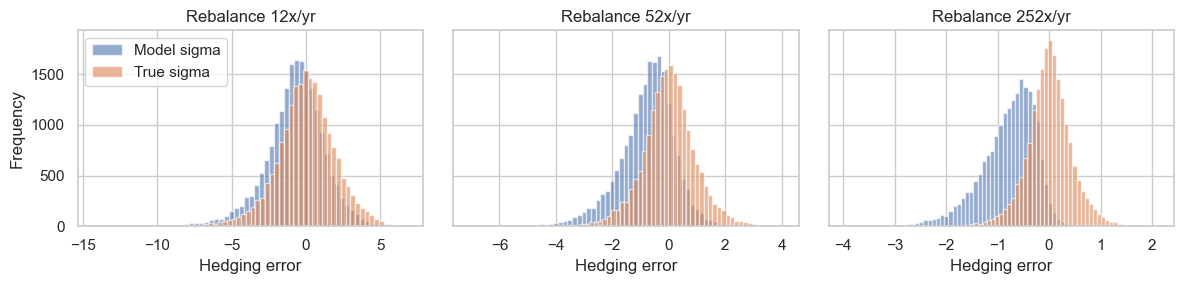

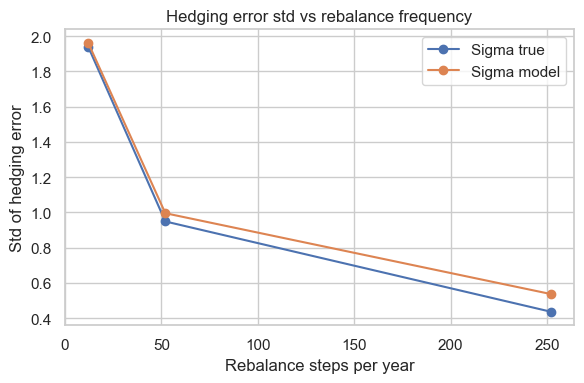

In [16]:
def hedging_errors(rebalance_steps: int, n_paths: int, seed: int, sigma_model: float) -> np.ndarray:
    t_grid, paths = simulate_gbm_paths(S0, r, sigma_true, T, n_steps, n_paths, seed=seed)

    price0 = black_scholes_call(S0, K_atm, T, r, sigma_model)
    delta0 = bs_delta_call(S0, K_atm, T, r, sigma_model)

    rebalance_idx = np.linspace(0, n_steps, rebalance_steps + 1, dtype=int)

    cash = np.full(n_paths, price0 - delta0 * S0, dtype=float)
    delta = np.full(n_paths, delta0, dtype=float)

    for k in range(1, len(rebalance_idx)):
        idx_prev = rebalance_idx[k - 1]
        idx_now = rebalance_idx[k]
        dt = t_grid[idx_now] - t_grid[idx_prev]
        cash *= np.exp(r * dt)

        S_now = paths[:, idx_now]
        tau = max(T - t_grid[idx_now], 0.0)
        if tau > 0:
            delta_new = bs_delta_call_vec(S_now, K_atm, tau, r, sigma_model)
        else:
            delta_new = np.where(S_now > K_atm, 1.0, 0.0)
        cash -= (delta_new - delta) * S_now
        delta = delta_new

    S_T = paths[:, -1]
    payoff = np.maximum(S_T - K_atm, 0.0)
    portfolio = cash + delta * S_T
    return portfolio - payoff


rebalance_steps_list = [12, 52, 252]

n_paths_hedge = 20_000
seed_hedge = seed_list[0]

errors_model = {
    steps: hedging_errors(steps, n_paths_hedge, seed_hedge, sigma_model_base)
    for steps in rebalance_steps_list
}
errors_true = {
    steps: hedging_errors(steps, n_paths_hedge, seed_hedge, sigma_true)
    for steps in rebalance_steps_list
}

fig, axes = plt.subplots(1, len(rebalance_steps_list), figsize=(12, 3), sharey=True)
for ax, steps in zip(axes, rebalance_steps_list):
    ax.hist(errors_model[steps], bins=60, alpha=0.6, label="Model sigma")
    ax.hist(errors_true[steps], bins=60, alpha=0.6, label="True sigma")
    ax.set_title(f"Rebalance {steps}x/yr")
    ax.set_xlabel("Hedging error")

axes[0].set_ylabel("Frequency")
axes[0].legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "hedging_error_hist.png"), dpi=150)
plt.show()

std_model = [float(np.std(errors_model[steps], ddof=1)) for steps in rebalance_steps_list]
std_true = [float(np.std(errors_true[steps], ddof=1)) for steps in rebalance_steps_list]

plt.figure(figsize=(6, 4))
plt.plot(rebalance_steps_list, std_true, marker="o", label="Sigma true")
plt.plot(rebalance_steps_list, std_model, marker="o", label="Sigma model")
plt.xlabel("Rebalance steps per year")
plt.ylabel("Std of hedging error")
plt.title("Hedging error std vs rebalance frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "hedging_error_std_vs_rebalance.png"), dpi=150)
plt.show()

In [17]:
import time
from IPython.display import update_display

elapsed = time.perf_counter() - notebook_start_time
update_display(f"Notebook runtime: {elapsed:.2f}s", display_id="notebook_runtime")